In [ ]:
# IMpressionist art GAN - Now has training between discriminator & generator as separate
import numpy as np
from numpy import expand_dims
from google.colab import drive
drive.mount('/content/drive')
from numpy import zeros
from numpy import ones
import tensorflow as tf
from numpy import vstack
from numpy.random import randint, randn
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Dropout, LeakyReLU
import pickle
from matplotlib import pyplot
# change to 64 as needed
IMAGE_DIMS = 128



def generator(rand_inp):
	model = Sequential()
  # gotta change depending onour image size
	n_nodes = 256 * 8 * 8
	model.add(Dense(n_nodes, input_dim=rand_inp))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 256)))
	# Up to 16 by 16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# Up to 32 by 32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# 64 by 64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 # 128 by 128 - probably shouldnt go any bigger
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# Three channels for R, G, B
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# Discriminator - between real & fake images
def discriminator(in_shape=(IMAGE_DIMS,IMAGE_DIMS,3)):
  optim = Adam(lr=0.0002, beta_1=0.5)
  model = Sequential()
	# normal
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
  return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generativeModel, discriminatingModel):
	# make weights in the discriminator not trainable
  d_model.trainable = False
  lamb=0.0002
  optim = Adam(lr=lamb, beta_1=0.5)

  #Model - just combination of two
  model = Sequential()
  model.add(generativeModel)
  model.add(discriminatingModel)
  model.compile(loss='binary_crossentropy', optimizer=optim)
  return model

# load and prepare pickled impressionist images
def load_real_samples():
	# load pickled data
  filename = '/content/drive/My Drive/training_data.pickle'
  trainX = None
  with open(filename, 'rb') as infile:
    trainX = pickle.load(infile)
  trainX = np.array([tf.image.resize(i, (IMAGE_DIMS, IMAGE_DIMS)) for i in trainX])
  
  X = trainX.astype('float32')
  
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

# random noiseinput for generator
def generate_rand_seed(rand_inp, n_samples):
	
	x_input = randn(rand_inp * n_samples)
	x_input = x_input.reshape(n_samples, rand_inp)
	return x_input

# Actual images from dataset
def dataset_samples(dataset, nums):
	# choose random instances
	inst = randint(0, dataset.shape[0], nums)
	# retrieve selected images
	X = dataset[inst]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y



# GEnerator predictions
def generated_samples(g_model, rand_inp, n_samples):
	# generate points in latent space
	x_input = generate_rand_seed(rand_inp, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# GENERATED IMAGE SUMMARY 
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0

	for i in range(n * n):
	  # define subplot
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	
	filename = 'Romanticist_%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# Gives sample generations every 10 epochs
def summary(epoch, g_model, dataset, rand_inp, n_samples=150):
	x_gen, y_gen = generated_samples(g_model, rand_inp, n_samples)

	
	save_plot(x_gen, epoch)
	# intermediary saving
	filename = 'ROmanticist_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# TRAIN LOOP
def train(g_model, d_model, gan_model, dataset, rand_noise, n_epochs=300, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	
	for i in range(n_epochs):
		
		for j in range(bat_per_epo):
			# dataset images
			X_real, y_real =dataset_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
		
			X_fake, y_fake = generated_samples(g_model, rand_noise, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			

			X_gan = generate_rand_seed(rand_noise, n_batch)
			y_gan = ones((n_batch, 1))
			
      #generator loss 
			g_loss = gan_model.train_on_batch(X_gan, y_gan)

			print(':%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

		if (i+1) % 10 == 0:
			summary(i, g_model, dataset, rand_noise)


random_input= 100
gen = generator(random_input)
disc = discriminator()


gan = define_gan(gen, disc)

dataset = load_real_samples()



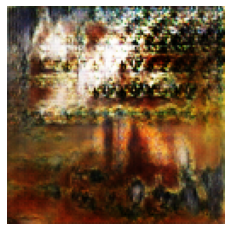

In [23]:
# Image gen
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_rand_seed(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = g_model
# generate images
random_origin = generate_rand_seed(100, 100)
# generate images
X = model.predict(random_origin)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 1)

In [ ]:
dataset.shape

(50000, 32, 32, 3)

In [6]:
dataset.shape

(8205, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


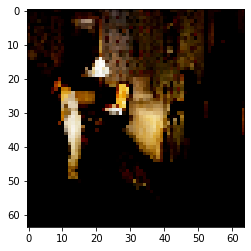

In [9]:
import matplotlib.pyplot as plt
plt.imshow(dataset[0])

In [ ]:
train(gen, disc, gan, dataset, random_input)